In [98]:
# -*- coding: UTF-8 -*-
from __future__ import print_function

import os

import cv2
import copy
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

data_dir = './data'
data_raw_dir = './data/raw/'
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

debug = False

In [99]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(30,30), ratio=1, conv_color = False):
    
    if conv_color:
        list_of_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in list_of_images]
    
    num_img = len(list_of_images)
    row = math.ceil( num_img / no_of_columns )
    
    if figsize[1] == 0:
        fig = plt.figure(figsize=(figsize[0], figsize[0]*row/no_of_columns/ratio))
    else:
        fig = plt.figure(figsize=figsize)
        
    for i, img in enumerate(list_of_images):
        if list_of_titles != []:
            fig.add_subplot( row, no_of_columns , i+1, title = list_of_titles[i])
        else:
            fig.add_subplot( row, no_of_columns , i+1)
        plt.imshow(list_of_images[i])
        plt.axis('off')
    plt.show()

In [196]:
def preprocess(gray):
    ret, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    ele = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 10))
    dilation = cv2.dilate(binary, ele, iterations=1)
    cv2.imwrite("binary.png", binary)
    cv2.imwrite("dilation.png", dilation)

    return dilation


def findTextRegion(img):
    region = []
    # 1. 查找轮廓
    img, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 2. 筛选那些面积小的
    for i in range(len(contours)):
        cnt = contours[i]
        # 计算该轮廓的面积
        area = cv2.contourArea(cnt)

        # 面积小的都筛选掉
        if (area < 300):
            continue

        # 轮廓近似，作用很小
        epsilon = 0.001 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # 找到最小的矩形，该矩形可能有方向
        rect = cv2.minAreaRect(cnt)
        if debug:
            print("rect is: ", rect)

        # box是四个点的坐标
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # 计算高和宽
        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])

        # 筛选那些太细的矩形，留下扁的
        if (height > width * 1.2):
            continue
        # 太扁的也不要
        if (height * 18 < width):
            continue
        if (width > img.shape[1] / 2 and height > img.shape[0] / 20):
            region.append(box)

    return region


def detect(img):
    # fastNlMeansDenoisingColored(InputArray src, OutputArray dst, float h=3, float hColor=3, int templateWindowSize=7, int searchWindowSize=21 )
    gray = cv2.fastNlMeansDenoisingColored(img, None, 10, 3, 3, 3)
    coefficients = [0, 1, 1]
    m = np.array(coefficients).reshape((1, 3))
    gray = cv2.transform(gray, m)
    if debug:
        cv2.imwrite("gray.png", gray)

    # 2. 形态学变换的预处理，得到可以查找矩形的图片
    dilation = preprocess(gray)

    # 3. 查找和筛选文字区域
    region = findTextRegion(dilation)

    # 4. 用绿线画出这些找到的轮廓
    raw_imgs = os.listdir(data_raw_dir)
    num_raw_imgs = len(raw_imgs)
    
    for box in region:
        h = abs(box[0][1] - box[2][1])
        w = abs(box[0][0] - box[2][0])
        Xs = [i[0] for i in box]
        Ys = [i[1] for i in box]
        x1 = min(Xs)
        y1 = min(Ys)
        cv2.drawContours(img, [box], 0, (0, 255, 0), 2)
        if w > 0 and h > 0 and x1 < gray.shape[1] / 2:
#             idImg = grayImg(img[y1:y1 + h, x1:x1 + w])
            idImg = img[y1:y1 + h, x1:x1 + w]
#             cv2.imwrite(data_raw_dir + str(num_raw_imgs) + ".png", idImg)
            break

    if debug:
        # 带轮廓的图片
        cv2.imwrite("contours.png", img)
        
    return idImg


def crop_image(img, tol=0):
    mask = img < tol
    return img[np.ix_(mask.any(1), mask.any(0))]


def ocrIdCard(imgPath, realId=""):
    img = cv2.imread(imgPath, cv2.IMREAD_COLOR)
    grid_display([img], [], 1, (8,8), 1, conv_color = True)
    
    img = cv2.resize(img, (428, 270), interpolation=cv2.INTER_CUBIC)
    idImg = detect(img)

    if debug:
        f, axarr = plt.subplots(2, 3)
        axarr[0, 0].imshow(cv2.imread(imgPath))
        axarr[0, 1].imshow(cv2.imread("gray.png"))
        axarr[0, 2].imshow(cv2.imread("binary.png"))
        axarr[1, 0].imshow(cv2.imread("dilation.png"))
        axarr[1, 1].imshow(cv2.imread("contours.png"))
        axarr[1, 2].set_title("exp:" + realId + "\nocr:" + result)
        axarr[1, 2].imshow(cv2.imread("0.png"))
        plt.show()
        
    return idImg


def decode(y):
    y = np.argmax(y, axis=1)
#     print(y)
    return ''.join([txt[x] for x in y])


def order_insert(list_rect, rect_inst):
    if list_rect == []:
        return [rect_inst]
    
    for i, rect in enumerate(list_rect):
        if rect_inst[0] < rect[0]:
            list_rect.insert(i, rect_inst)
            break
            
    return list_rect

def split_digit(img):
    # resizeimg
#     img = cv2.resize(img, (img.shape[1] * 3, img.shape[0] * 3), interpolation=cv2.INTER_CUBIC)
    # clone backup
    image_bgr  = copy.copy(img)
    # to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # to binary
    retval, gray = cv2.threshold(gray, 120, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
    # find contours
    gray, contours, hierarchy = cv2.findContours(gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # crop digits aoccording to contours
    digit_rects = []
    rois = []
    for cnt in contours[-18:]:
        x,y,w,h = cv2.boundingRect(cnt)
        roi_rect = [x,y,x+w,y+h]
        digit_rects = order_insert(digit_rects, roi_rect)
    
    for rt in digit_rects:
        roi=image_bgr[ rt[1]-2:rt[3]+2, rt[0]-5:rt[2]+5 ]
        reg_roi = cv2.resize( roi, (28,28) )
        rois.append(reg_roi)
    #     cv2.rectangle(image2,(rt[0],rt[1]),(rt[2],rt[3]),(200,0,0),2)
    #     print (rt[0], end = ' ')
    return rois

### Train model

In [154]:
# dimensions of our images.
img_width, img_height = 28, 28
charset_size = 11
nb_validation_samples = 11
nb_samples_per_epoch = 11
nb_nb_epoch = 20
txt = "0123456789X"
log_filepath = '/tmp/keras_log'

def train(model):
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=1024,
        color_mode="grayscale",
        class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=1024,
        color_mode="grayscale",
        class_mode='categorical')

    model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(),
                  metrics=['accuracy'])

    tb_cb = keras.callbacks.TensorBoard(log_dir=log_filepath, write_images=1, histogram_freq=1)
    # 设置log的存储位置，将网络权值以图片格式保持在tensorboard中显示，设置每一个周期计算一次网络的
    # 权值，每层输出值的分布直方图
    cbks = [tb_cb]

    model.fit_generator(train_generator,
                        steps_per_epoch=nb_samples_per_epoch,
                        epochs=nb_nb_epoch,
                        validation_data=validation_generator,
                        validation_steps=nb_validation_samples,
                        )



def build_model(input_shape=(28, 28, 1), classes=charset_size):
    img_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    x = Dropout(0.1)(x)
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.1)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    model = Model(img_input, x, name='model')
    # 训练的正确率和误差，acc和loss 验证集正确率和误差val_acc和val_loss
    return model


# model = build_model()
# train(model)
# model.save("./model.h5")



### extract id number roi

In [205]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]): 
    # construct matrix with weight (28,28,3)
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    # assert( tile.shape == im.shape )
    # sum RGB with weight [ 0.2989, 0.587 , 0.114 ]
    return np.sum(tile * im, axis=2) 

def simple_threshold(im, threshold=128): 
    return ((im > threshold) * 255).astype("uint8") 

In [206]:
def otsu_threshold(im): 
    pixel_counts = [np.sum(im == i) for i in range(256)] # 得到图片的以0-255索引的像素值个数列表 
    s_max = (0,-10) 
    ss = [] 
    for threshold in range(256): 
        # 遍历所有阈值，根据公式挑选出最好的 
        # 更新
        w_0 = sum(pixel_counts[:threshold]) # 得到阈值以下像素个数 
        w_1 = sum(pixel_counts[threshold:]) # 得到阈值以上像素个数 
        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0 
        # 得到阈值下所有像素的均值 
        # 注意 if else 用法意义： 如果 w_0 > 0 则 mu_0 = sum/w_0 否则 mu_0 = 0 
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0 # 得到阈值上所有像素的均值 
        # 根据公式计算 
        s = 1.0 * w_0 * w_1 * (mu_0 - mu_1) ** 2 # 直接使用w_0 * w_1可能会造成整数相乘溢出，所以先乘一个1.0变为浮点数 
        ss.append(s) # 取最大的 
        if s > s_max[1]: 
            s_max = (threshold, s) 
            return s_max[0]

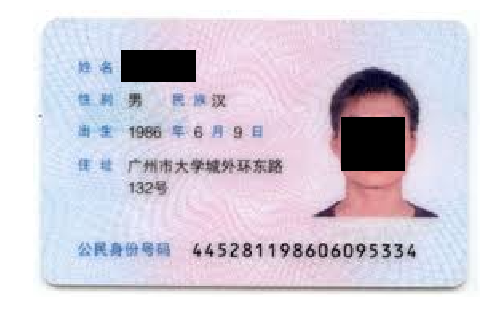

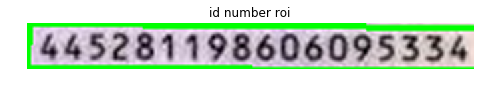

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


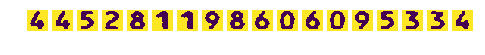

In [209]:
# if __name__ == '__main__':

# extract id number roi
number_roi_img = ocrIdCard("test0.png")
# enlarge img
number_roi_img = cv2.resize(number_roi_img, (number_roi_img.shape[1] * 3, number_roi_img.shape[0] * 3), interpolation=cv2.INTER_CUBIC)
grid_display([number_roi_img], ['id number roi'], 1, (8,8), 1, conv_color = False)
# split roi image
rois = split_digit(number_roi_img)

# process without opencv
digit_imgs = []
for digit_img in rois[-18:]:
    gray = to_grayscale(digit_img)
    # calculate otsu_threshold
    t = otsu_threshold(gray)
#     print (t)
    binary = simple_threshold(gray)
    digit_imgs.append(binary)
    
grid_display(digit_imgs, [], 18, (8,8), 1, conv_color = False)


### predict digits with CNN

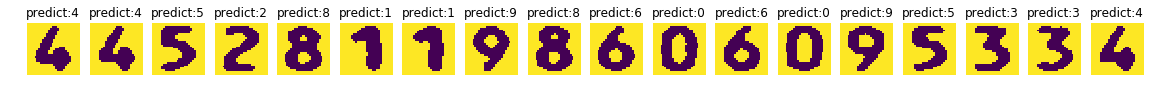

In [194]:
# predict digit with CNN
filename = "445281198606095334.png"
model = load_model("./model.h5")
titles = []
for img in digit_imgs:
#     img.save("data/train/" + filename[i] + "/" + str(i) + "-" + filename)
    x = img_to_array(img)
    # reshape to array rank 4
    x = x.reshape((-1,) + x.shape)
#     print(x.shape)
    y_pred = model.predict(x)
#     print(model.predict(x))
    titles.append( 'predict:%s' % (decode(y_pred) ) )

grid_display(digit_imgs, titles, 18, (20,8), 1, conv_color = False)